Import Libraries

In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller


Data Extraction (YFinance)

In [10]:
tickers = ["TSLA", "BND", "SPY"]
start_date = "2015-01-01"
end_date = "2026-01-15"

data = {}

for ticker in tickers:
    df = yf.download(ticker, start=start_date, end=end_date)
    df["Asset"] = ticker
    data[ticker] = df


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Basic Data Understanding

In [11]:
data["TSLA"].head()
data["TSLA"].info()
data["TSLA"].describe()


<class 'pandas.DataFrame'>
DatetimeIndex: 2775 entries, 2015-01-02 to 2026-01-14
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, TSLA)   2775 non-null   float64
 1   (High, TSLA)    2775 non-null   float64
 2   (Low, TSLA)     2775 non-null   float64
 3   (Open, TSLA)    2775 non-null   float64
 4   (Volume, TSLA)  2775 non-null   int64  
 5   (Asset, )       2775 non-null   str    
dtypes: float64(4), int64(1), str(1)
memory usage: 151.8 KB


Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
count,2775.000000,2775.000000,2775.000000,2775.000000,2.775000e+03
mean,138.472937,141.534064,135.271181,138.505925,1.108480e+08
std,131.682073,134.616345,128.668762,131.791350,7.145365e+07
min,9.578000,10.331333,9.403333,9.488000,1.062000e+07
25%,17.851666,18.087000,17.588000,17.836666,6.758150e+07
50%,91.625999,94.484001,89.113998,93.066666,9.264600e+07
75%,242.028336,247.846664,236.978333,242.901665,1.282366e+08
max,489.880005,498.829987,485.329987,489.880005,9.140820e+08


Handle Missing Values

In [14]:
for ticker, df in data.items():
    print(ticker)
    print(df.isna().sum())
    df.ffill(inplace=True)


TSLA
Price   Ticker
Close   TSLA      0
High    TSLA      0
Low     TSLA      0
Open    TSLA      0
Volume  TSLA      0
Asset             0
dtype: int64
BND
Price   Ticker
Close   BND       0
High    BND       0
Low     BND       0
Open    BND       0
Volume  BND       0
Asset             0
dtype: int64
SPY
Price   Ticker
Close   SPY       0
High    SPY       0
Low     SPY       0
Open    SPY       0
Volume  SPY       0
Asset             0
dtype: int64


Feature Engineering – Daily Returns

In [20]:
for ticker, df in data.items():
    df.columns = [col[0] if col[0] != "Asset" else "Asset" for col in df.columns]
    df.ffill(inplace=True)
    df["Daily Return"] = df["Close"].pct_change()


Price Trend Visualization

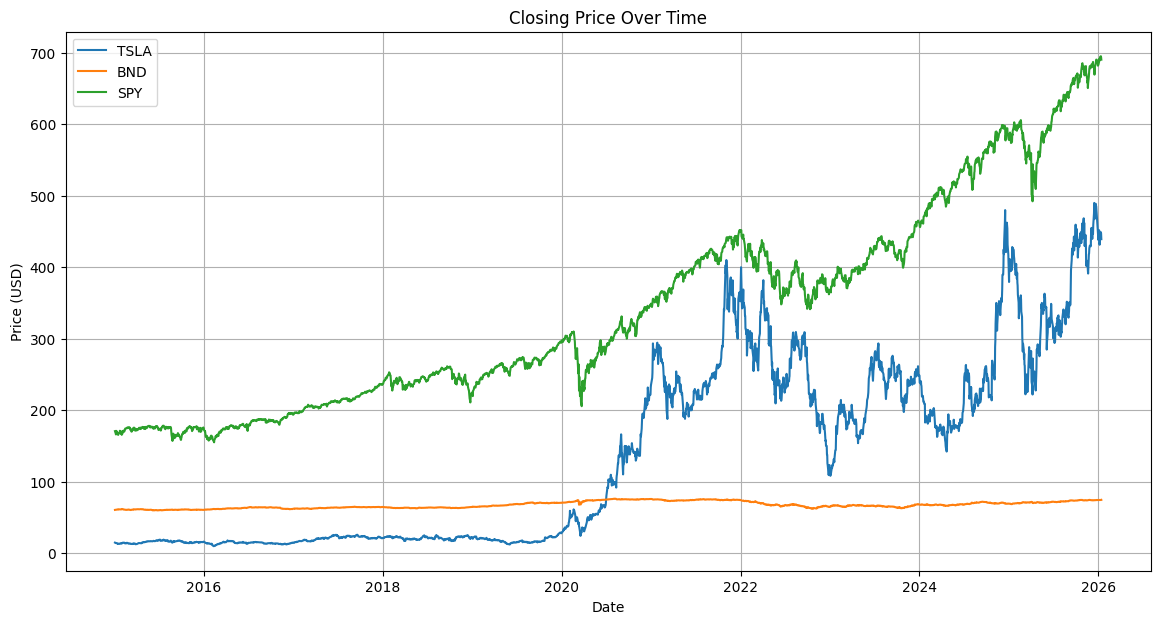

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,7))
for ticker in data.keys():
    plt.plot(data[ticker].index, data[ticker]["Close"], label=ticker)

plt.title("Closing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()


Volatility Analysis – Daily Returns

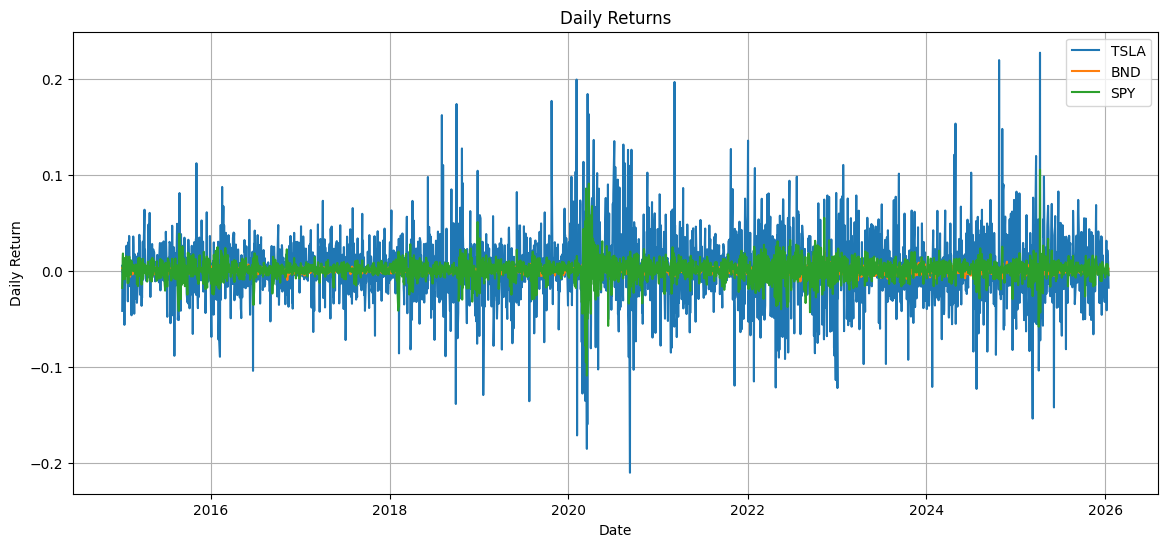

In [22]:
plt.figure(figsize=(14,6))
for ticker in data.keys():
    plt.plot(data[ticker].index, data[ticker]["Daily Return"], label=ticker)

plt.title("Daily Returns")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.legend()
plt.grid(True)
plt.show()


Rolling Volatility (30 Days)

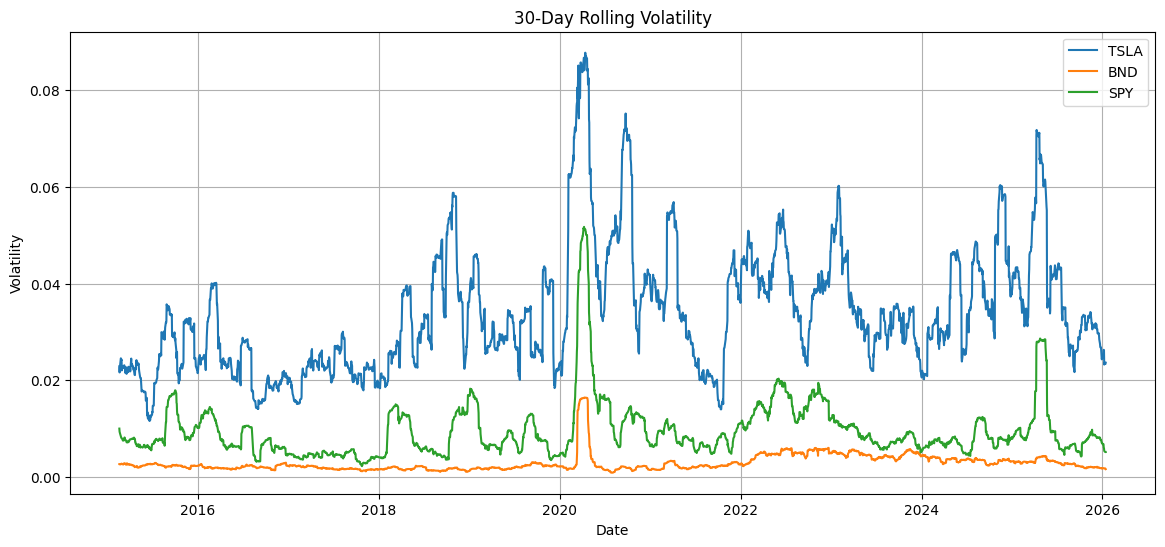

In [23]:
rolling_window = 30  # days
plt.figure(figsize=(14,6))

for ticker, df in data.items():
    df["Rolling Volatility"] = df["Daily Return"].rolling(window=rolling_window).std()
    plt.plot(df.index, df["Rolling Volatility"], label=ticker)

plt.title(f"{rolling_window}-Day Rolling Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.show()


Outlier Detection

In [25]:
outlier_threshold = 0.1  # 10% daily return
for ticker, df in data.items():
    outliers = df[df["Daily Return"].abs() > outlier_threshold]
    print(f"\n{ticker} Outliers (|Daily Return| > {outlier_threshold}):")
    display(outliers[["Close", "Daily Return"]].head())



TSLA Outliers (|Daily Return| > 0.1):


,Close,Daily Return
Date,,
2015-11-04,15.442000,0.111735
2016-06-22,13.110667,-0.104503
2018-08-02,23.302668,0.161880
2018-08-07,25.304667,0.109886
2018-09-28,17.651333,-0.139015



BND Outliers (|Daily Return| > 0.1):


,Close,Daily Return
Date,,



SPY Outliers (|Daily Return| > 0.1):


,Close,Daily Return
Date,,
2020-03-16,219.789749,-0.109424
2025-04-09,543.883484,0.105019


Stationarity Testing (ADF Test)

In [26]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series.dropna())
    return {
        "ADF Statistic": result[0],
        "p-value": result[1]
    }

for ticker, df in data.items():
    print(f"\nADF Test on {ticker} Closing Prices:")
    display(adf_test(df["Close"]))

    print(f"ADF Test on {ticker} Daily Returns:")
    display(adf_test(df["Daily Return"]))



ADF Test on TSLA Closing Prices:


{'ADF Statistic': np.float64(-0.7801569882105652),
 'p-value': np.float64(0.8248814297221106)}

ADF Test on TSLA Daily Returns:


{'ADF Statistic': np.float64(-53.0196185442436), 'p-value': 0.0}


ADF Test on BND Closing Prices:


{'ADF Statistic': np.float64(-1.0513787313888967),
 'p-value': np.float64(0.7340672086021968)}

ADF Test on BND Daily Returns:


{'ADF Statistic': np.float64(-10.433765839087226),
 'p-value': np.float64(1.5858141197309593e-18)}


ADF Test on SPY Closing Prices:


{'ADF Statistic': np.float64(1.1708806571588837),
 'p-value': np.float64(0.9957783900255509)}

ADF Test on SPY Daily Returns:


{'ADF Statistic': np.float64(-17.228850712811916),
 'p-value': np.float64(6.211405776206157e-30)}

Risk Metrics – Value at Risk (VaR) & Sharpe Ratio

In [27]:
import numpy as np

confidence_level = 0.05
risk_free_rate = 0.02 / 252  # daily risk-free rate

risk_metrics = {}

for ticker, df in data.items():
    returns = df["Daily Return"].dropna()
    
    VaR_95 = np.percentile(returns, confidence_level*100)
    sharpe = (returns.mean() - risk_free_rate) / returns.std()
    
    risk_metrics[ticker] = {"VaR_95": VaR_95, "Sharpe Ratio": sharpe}

# Display metrics
import pandas as pd
pd.DataFrame(risk_metrics).T


,VaR_95,Sharpe Ratio
TSLA,-0.052529,0.049672
BND,-0.004796,0.000510
SPY,-0.016719,0.043556


Save Cleaned Data

In [29]:
data["TSLA"].to_csv("../data/processed/tsla_processed.csv")
data["SPY"].to_csv("../data/processed/spy_processed.csv")
data["BND"].to_csv("../data/processed/bnd_processed.csv")
